In [3]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [4]:
# set project path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/'

In [5]:
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)

# get first row for any future operations
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map = df_map.iloc[1:,]

# remove separate and together columns
df_map = df_map.drop(['Separate','Together'], axis=1)

# subset on useful columns
# TwinPair and Diagnosis are useful columns
df_map = df_map.loc[:,['TwinPair','Diagnosis']]

df_map.head()

,TwinPair,Diagnosis
#SampleID,,
500A.Fecal,T2,RA
501A.Fecal,T2,Unaffected
502A.Fecal,T3,RA
503A.Fecal,T3,Unaffected
504A.Fecal,T4,RA


In [6]:
# loop over L3, L6 and L7
# look at Clostridia and Bacteroidia 
Lx_to_df = {}
Lx_to_str = {
    'L3': 'level-3_10k',
    'L6': 'level-6_10k',
    'L7': 'level-7_10k'
}

for l in Lx_to_str:
    df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB/' + Lx_to_str[l] + '.csv',index_col=0)
    
    df_diag = df_otu['Diagnosis']
    otu_cols = []

    for c in list(df_otu.columns.values):
        if '__' in c:
            otu_cols.append(c)

    # subset on OTU
    df_otu = df_otu.loc[:,otu_cols]

    # divide by row sum (i.e. sample count) to normalize
    df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
    
    # save to dict
    Lx_to_df[l] = df_otu

df_otu.head()

,Unassigned;__;__;__;__;__;__,k__Archaea;__;__;__;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea;s__devanaterra,k__Archaea;p__Euryarchaeota;c__DSEG;o__ArcA07;f__;g__;s__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,...,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__Ellin517;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__R4-41B;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__auto67_4W;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__;s__,k__Bacteria;p__WPS-2;c__;o__;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;__;__;__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__;s__,k__Bacteria;p__ZB3;__;__;__;__;__,k__Bacteria;p__ZB3;c__BS119;o__;f__;g__;s__
index,,,,,,,,,,,,,,,,,,,,,
182A.Fecal,0.0,0.00000,0.000148,0.0,0.0,0.00000,0.001531,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000605,0.0,0.000594,0.0,0.0,0.0,0.000000
183A.Fecal,0.0,0.00012,0.000167,0.0,0.0,0.00047,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000375,0.0,0.000120,0.0,0.0,0.0,0.000000
500A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002825,0.0,0.000000,0.0,0.0,0.0,0.000000
501A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.001800,0.0,0.0,0.0,0.000000
502A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.002229


0.8134628971746307 0.4394903313705615


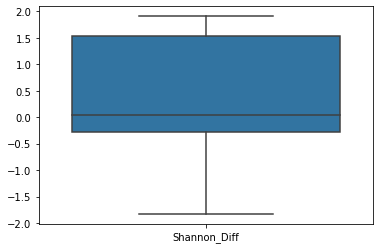

In [7]:
# paired shannon diversity difference from 0 
df_alpha = pd.read_csv(path + 'inputs/Qiime2_0_KB/shannon_metadata_10k.tsv', sep='\t', index_col=0)

# drop unnecessary rows and cols
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha.drop('Separate', axis=1)
df_alpha = df_alpha.drop(['Elutionbuffer1','Elutionbuffer2','blank'])

# get paired per twin pair
pair_to_diff = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    alpha_UA = float(df[df['Diagnosis'] == 'Unaffected']['shannon_entropy'].values)
    alpha_RA = float(df[df['Diagnosis'] == 'RA']['shannon_entropy'].values)
    pair_to_diff[p] = alpha_RA - alpha_UA

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['Shannon_Diff'])

# drop T1
df_paired_alpha = df_paired_alpha.drop('T1')

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha['Shannon_Diff'],popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=df_paired_alpha)

-0.6227105477161288 0.5367634090691689


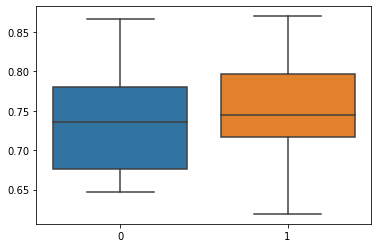

In [8]:
# paired beta div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
df_beta = pd.read_csv(path + 'inputs/Qiime2_0_KB/core_metrics_10k/unweighted_unifrac_distance_matrix.tsv', sep='\t', index_col=0)

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    id_UA = str(df[df['Diagnosis'] == 'Unaffected'].index.values[0])
    id_RA = str(df[df['Diagnosis'] == 'RA'].index.values[0])
    pair_to_ids[p] = (id_UA, id_RA)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_UA, id_RA]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Dist'])
df_paired_beta = df_paired_beta.drop('T1')

# grab inter RA distances
df_raw = pd.read_csv(path + 'inputs/Qiime2_0_KB/unweighted_raw_data.tsv', sep='\t', index_col=0)
df_RA = df_raw[df_raw['Group1'] == 'RA']
df_RA = df_RA[df_RA['Group2'] == 'RA']

# compare distances
inter_twin = df_paired_beta['Unweighted_Dist'].values
inter_RA = df_RA['Distance'].values

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
print(t, p)

sns.boxplot([inter_twin, inter_RA])

In [9]:
# Q1 Q2 comparison
# get OTU table from RB
df1 = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/3_taxa.summary_qiime/all_by.sample/otu_table_RA.twins_16S_all_L3.txt', sep='\t', skiprows=1)
df1 = df1.set_index('#OTU ID').T
df1 = df1.drop(['182A.Fecal','183A.Fecal','Elutionbuffer1','Elutionbuffer2'])#
df1.to_csv(path + 'inputs/Qiime2_0_KB/otu_table_L3_Q1.csv')

for l in ['3','6','7']:
    # normalize OTU table and get Q2 version
    df2 = pd.read_csv(path + 'inputs/Qiime2_0_KB/level-' + l + '.csv', index_col=0)
    keep_cols = []
    for c in list(df2.columns.values):
        if '__' in c:
            keep_cols.append(c)
    df2 = df2[keep_cols]
    df2.to_csv(path + 'inputs/Qiime2_0_KB/counts_table_L' + l + '_Q2.csv')
    df2 = df2.div(df2.sum(axis=1), axis=0)
    df2.to_csv(path + 'inputs/Qiime2_0_KB/otu_table_L' + l + '_Q2.csv')
df2.head()


,Unassigned;__;__;__;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea;s__devanaterra,k__Archaea;p__Euryarchaeota;c__DSEG;o__ArcA07;f__;g__;s__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;s__,...,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__;s__,k__Bacteria;p__WPS-2;c__;o__;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;__;__;__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__;s__,k__Bacteria;p__ZB3;__;__;__;__;__,k__Bacteria;p__ZB3;c__BS119;o__;f__;g__;s__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus;s__,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus;s__
index,,,,,,,,,,,,,,,,,,,,,
500A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.002474,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.002192,0.00000
501A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.000000,0.0,0.001672,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.00000
502A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.002134,0.0,0.000000,0.00000
503A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0024,0.0,0.001016,0.0,...,0.000000,0.0,0.000000,0.0,0.00226,0.0,0.000000,0.0,0.000000,0.00000
504A.Fecal,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.02143


1.2693184558038249 0.24489831883583527


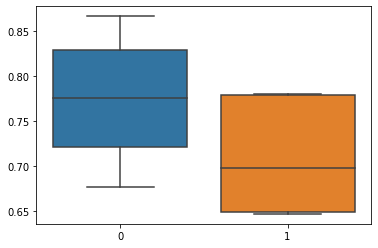

In [10]:
# investigate whether MTX treated twins converge to unaffected twins

# manually input metadata from Patient_data_KB.xls
samp_to_MTX = {
    '500A.Fecal': 1,
    '502A.Fecal': 1,
    '504A.Fecal': 1,
    '506A.Fecal': 0, # other DMARDs
    '508A.Fecal': 0, # unclear? HCQ
    '510A.Fecal': 1,
    '512A.Fecal': 1,
    '514A.Fecal': 0, # previosuly, not currently
    '516A.Fecal': 0, # in 2012, not currently,
}

# to treatment
samp_to_tmt = {
    '500A.Fecal': 1, # MTX
    '502A.Fecal': 1, # MTX
    '504A.Fecal': 1, # MTX
    '506A.Fecal': 1, # other DMARDs
    '508A.Fecal': 0, # unclear? HCQ
    '510A.Fecal': 1,
    '512A.Fecal': 1,
    '514A.Fecal': 0, # previosuly, not currently
    '516A.Fecal': 0, # in 2012, not currently,
}

# get copy
df_meta = df_map.copy()

# replace with column dict per above
df_meta['MTX'] = df_meta.index.map(samp_to_MTX)

# replace nan with 0 i.e. untreated
df_meta['MTX'] = df_meta['MTX'].fillna(0) 

# create TwinPair to MTX mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_MTX = df['MTX'].to_dict()

# Things to ask
# 1. Do the twin pair distances decrease in treated vs untreated twins?
df_paired_beta['MTX'] = df_paired_beta.index.map(TP_to_MTX)

# compare distances
inter_untreated = df_paired_beta[df_paired_beta['MTX'] == 0]['Unweighted_Dist']
inter_treated = df_paired_beta[df_paired_beta['MTX'] == 1]['Unweighted_Dist']

t, p = scipy.stats.ttest_ind(inter_untreated, inter_treated)
print(t, p)

sns.boxplot([inter_untreated, inter_treated])


0.39379289109051174 0.2943428384999882
0.8028200723091462 0.009188156493005662


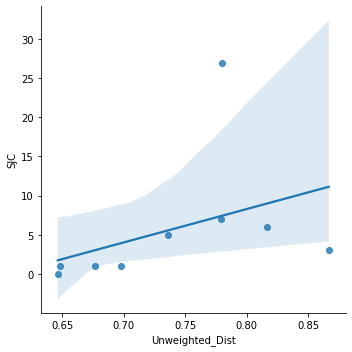

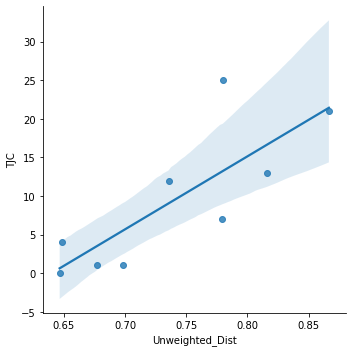

In [11]:
# add in metadata TJC and SJC
samp_to_TJC = {
    '501A.Fecal': 0,
    '503A.Fecal': 2,
    '505A.Fecal': 8,
    '507A.Fecal': 0,
    '509A.Fecal': 0,
    '511A.Fecal': 0,
    '513A.Fecal': 0,
    '515A.Fecal': 0,
    '500A.Fecal': 1, 
    '502A.Fecal': 7, 
    '504A.Fecal': 25, 
    '506A.Fecal': 21, 
    '508A.Fecal': 13,
    '510A.Fecal': 0,
    '512A.Fecal': 4,
    '514A.Fecal': 12, 
    '516A.Fecal': 1,
    '517A.Fecal': 0
}

samp_to_SJC = {
    '501A.Fecal': 0,
    '503A.Fecal': 0,
    '505A.Fecal': 2,
    '507A.Fecal': 0,
    '509A.Fecal': 0,
    '511A.Fecal': 0,
    '513A.Fecal': 0,
    '515A.Fecal': 0,
    '500A.Fecal': 1, 
    '502A.Fecal': 7, 
    '504A.Fecal': 27, 
    '506A.Fecal': 3, 
    '508A.Fecal': 6,
    '510A.Fecal': 0,
    '512A.Fecal': 1,
    '514A.Fecal': 5, 
    '516A.Fecal': 1,
    '517A.Fecal': 0
}

# why is 510 so well controlled...? even w/o steroids
# Actinomycetales?

# correlate SJC/TJC with distance
df_meta = df_map.copy()

# replace with column dict per above
df_meta['TJC'] = df_meta.index.map(samp_to_TJC)
df_meta['SJC'] = df_meta.index.map(samp_to_SJC)

# create TwinPair to var mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_TJC = df['TJC'].to_dict()
TP_to_SJC = df['SJC'].to_dict()

# create column in paired beta
df_paired_beta['SJC'] = df_paired_beta.index.map(TP_to_SJC)
df_paired_beta['TJC'] = df_paired_beta.index.map(TP_to_TJC)

# conduct correlation
r, p = scipy.stats.pearsonr(x=df_paired_beta['Unweighted_Dist'],y=df_paired_beta['SJC'])
sns.lmplot(data=df_paired_beta, x='Unweighted_Dist', y='SJC')
print(r, p)

r, p = scipy.stats.pearsonr(x=df_paired_beta['Unweighted_Dist'],y=df_paired_beta['TJC'])
sns.lmplot(data=df_paired_beta, x='Unweighted_Dist', y='TJC')
print(r, p)



In [12]:
# prepare for CUTIE
df_meta.to_csv(path + 'inputs/Qiime2_0_KB/df_meta_all.tsv', sep='\t')
df_RA = df_meta[df_meta['Diagnosis'] == 'RA']
df_RA = df_RA.drop(['TwinPair', 'Diagnosis'], axis=1)
df_RA.to_csv(path + 'inputs/Qiime2_0_KB/df_meta_RA.tsv', sep='\t')

df_meta

,TwinPair,Diagnosis,TJC,SJC
#SampleID,,,,
500A.Fecal,T2,RA,1,1
501A.Fecal,T2,Unaffected,0,0
502A.Fecal,T3,RA,7,7
503A.Fecal,T3,Unaffected,2,0
504A.Fecal,T4,RA,25,27
505A.Fecal,T4,Unaffected,8,2
506A.Fecal,T5,RA,21,3
507A.Fecal,T5,Unaffected,0,0
508A.Fecal,T6,RA,13,6


In [13]:
# rename without Fecal suffix 
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)
df_map = df_map.reset_index()
new_sid = [x.replace('.Fecal','') for x in list(df_map['#SampleID'].values)]
df_map['#SampleID'] = new_sid
df_map = df_map.set_index('#SampleID')
df_map.to_csv(path + 'inputs/Qiime2_1_KB/qiime_mapping_file_noctrl_no182183_ensemble.tsv', sep='\t')
df_map

#df_map_replace = df_map.replace(to_replace='Fecal',value='')
#df_map_replace


,BarcodeSequence,LinkerPrimerSequence,Separate,SomeOtherInfo,Together,TwinPair,AliquotID,AliquotWeight,AliquotWeightUnit,SpecimenBodySite,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
500A,GTTATGACGGAT,CCGGACTACHVGGGTWTCTAAT,Limit 45 Characters,NaN,500A.Fecal,T2,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,500,NaN,NaN,fecal,NaN,NaN,NaN
501A,CCAATGATAAGC,CCGGACTACHVGGGTWTCTAAT,All,NaN,501A.Fecal,T2,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,501,NaN,NaN,fecal,NaN,NaN,NaN
502A,TCAATGACCGCA,CCGGACTACHVGGGTWTCTAAT,All,NaN,502A.Fecal,T3,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,502,NaN,NaN,fecal,NaN,NaN,NaN
503A,CTCTCATATGCT,CCGGACTACHVGGGTWTCTAAT,All,NaN,503A.Fecal,T3,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,503,NaN,NaN,fecal,NaN,NaN,NaN
504A,CATGTTGGAACA,CCGGACTACHVGGGTWTCTAAT,All,NaN,504A.Fecal,T4,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,504,NaN,NaN,fecal,NaN,NaN,NaN
505A,CGAGATAGTTTG,CCGGACTACHVGGGTWTCTAAT,All,NaN,505A.Fecal,T4,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,505,NaN,NaN,fecal,NaN,NaN,NaN
506A,ATGTTTAGACGG,CCGGACTACHVGGGTWTCTAAT,All,NaN,506A.Fecal,T5,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,506,NaN,NaN,fecal,NaN,NaN,NaN
507A,TGCGGGATTCAT,CCGGACTACHVGGGTWTCTAAT,All,NaN,507A.Fecal,T5,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,507,NaN,NaN,fecal,NaN,NaN,NaN


In [14]:
# pathway analysis
# load species table :) 
df_otu = pd.read_csv(path + 'outputs/ensemble_humann3/twinsra_combined_taxa_table.tsv', sep='\t', index_col=0).T

# collect individual pathway dfs
#pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_genefamilies.tsv')
pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_pathabundance.tsv')

# collect and parse dfs
dfs = []
for fp in pathway_fps:
    df = pd.read_csv(path + 'outputs/ensemble_humann3/' + fp.name, sep='\t', index_col=0)
    df = df/df.sum()
    dfs.append(df)

# merge dataframes
df_pathway = pd.concat(dfs, axis=1).T

# test first x pathways
# df_pathway = df_pathway.iloc[:,:100]

# conduct KW test
RA_ids = ['512A_Abundance',#-RPKs', 
          '516A_Abundance',#-RPKs',
          '508A_Abundance',#-RPKs', 
          '514A_Abundance',#-RPKs',
          '502A_Abundance',#-RPKs',
          '500A_Abundance',#-RPKs',
          '510A_Abundance',#-RPKs',
          '504A_Abundance']#-RPKs',

UA_ids = ['513A_Abundance',#-RPKs', 
          '517A_Abundance',#-RPKs', 
          '509A_Abundance',#-RPKs', 
          '515A_Abundance',#-RPKs',
          '503A_Abundance',#-RPKs', 
          '501A_Abundance',#-RPKs',
          '511A_Abundance',#-RPKs',
          '505A_Abundance']#-RPKs']

pathways = list(df_pathway.columns.values)
for x in pathways:
    plot = False
    RA_vals = df_pathway.loc[RA_ids,x].values
    UA_vals = df_pathway.loc[UA_ids,x].values
    h,p = scipy.stats.kruskal(RA_vals, UA_vals)
    if p < 0.05:
        print('KW')
        print(x)
        print(p)
        plot = True
    diff = RA_vals - UA_vals
    if sum(np.isnan(diff)) < 2:
        w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
        if p < 0.05:
            print('SR')
            print(x)
            print(p)
            plot = True
    if plot:
        #sns.stripplot([RA_vals, UA_vals])
        sns.boxplot([RA_vals, UA_vals])
        plt.title(x)
        plt.savefig(path + 'outputs/ensemble_humann3/' + x + '.pdf',  bbox_inches="tight")
        plt.close()



/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


KW
GLYCOGENSYNTH-PWY: glycogen biosynthesis I (from ADP-D-Glucose)
0.045999366875037154


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


SR
VALSYN-PWY: L-valine biosynthesis
0.03569190011680441
SR
PWY0-1586: peptidoglycan maturation (meso-diaminopimelate containing)|unclassified
0.03569190011680441
SR
CITRULBIO-PWY: L-citrulline biosynthesis|unclassified
0.0499499764547464


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [117]:
# prep for dgca
# df_pathway 8579 cols
df_path = pd.read_csv(path + 'outputs/ensemble_humann3/humann3_joined_pathabundance_no_misses_relabund.tsv', sep='\t', index_col=0)
df_path = df_path.T
df_path.index = df_path.index.map(lambda x: x.split('_')[0])
# len(df_path.columns)

# df_meta: TwinPair, Diagnosis, TJC and SJC
df_meta_edit = df_meta.copy()
df_meta_edit.index = df_meta_edit.index.map(lambda x: x.split('.')[0])

# species level, 760 columns
# df_otu
# len(df_otu.columns)

# OLINK cytokine data, 92 columns
# drop OG rows 2-10 (1 indexed) and 20, the avg of 501 and 503 are used b/c they have repeat measures
df_olink = pd.read_csv(path + 'inputs/RA_twins/Normalized Olink TWINRA_RBB/Norm_Olink_TWINRA_KB.csv', index_col='Sample ID')
df_olink = df_olink.drop(['mtx Responder?','Twin pair','Timepoint','Group','Project','Dx', 'barcode'], axis=1)
df_olink = df_olink.dropna()
df_olink = df_olink.iloc[8:,:]
df_olink.index = df_olink.index.map(lambda x: x.split('.')[1] + 'A')

# metabolites, fatty acids; 11 collumns
df_fa = pd.read_csv(path + 'inputs/RA_twins/Metabolites/metabolites_KB.csv', index_col=0)
df_fa = df_fa.drop(['Subject','Sibling_pair'], axis=1)
df_fa = df_fa.drop(['182A','183A', 'Missing 507A'])
df_fa = df_fa.dropna()

# combine them all!
df_final = pd.concat([df_meta_edit, df_otu, df_path, df_olink, df_fa], axis=1)
df_final = df_final.drop(['TwinPair'],axis=1)
df_final.columns = df_final.columns.map(lambda x: x.replace('\'','prime'))

# testing
df_final_test = df_final.iloc[:5,:4028]
df_final_test.to_csv(path + 'inputs/df_final_test.tsv', sep='\t',index_label='SampleID')

# drop TwinPair
df_final.to_csv(path + 'inputs/df_final.tsv', sep='\t',index_label='SampleID')


df_final_test




,Diagnosis,TJC,SJC,Acidaminococcus intestini,Acinetobacter SGB14792,Actinomyces SGB17154,Actinomyces SGB17157,Actinomyces bouchesdurhonensis,Actinomyces sp ICM58,Adlercreutzia caecimuris,...,PWY-5686: UMP biosynthesis I|g__Sellimonas.s__Sellimonas_intestinalis,PWY-5686: UMP biosynthesis I|g__Streptococcus.s__Streptococcus_parasanguinis,PWY-5686: UMP biosynthesis I|g__Streptococcus.s__Streptococcus_pneumoniae,PWY-5686: UMP biosynthesis I|g__Streptococcus.s__Streptococcus_salivarius,PWY-5686: UMP biosynthesis I|g__Streptococcus.s__Streptococcus_thermophilus,PWY-5686: UMP biosynthesis I|unclassified,PWY-5690: TCA cycle II (plants and fungi),PWY-5690: TCA cycle II (plants and fungi)|unclassified,PWY-5692: allantoin degradation to glyoxylate II,PWY-5695: inosine 5prime-phosphate degradation
500A,RA,1,1,0.027009,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000613,0.000093,0.000022,0.000000,0.011779
501A,Unaffected,0,0,0.000000,0.000581,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000037,0.000014,0.000084,0.0,0.001614,0.000231,0.000175,0.000000,0.009615
502A,RA,7,7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.001099,0.000342,0.000000,0.000000,0.010794
503A,Unaffected,2,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000550,0.000000,0.000000,0.000012,0.007962
504A,RA,25,27,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.002630,0.000000,0.000000,0.000000,0.011085


In [118]:
df_final_test.iloc[:,4025:4030]

,PWY-5690: TCA cycle II (plants and fungi)|unclassified,PWY-5692: allantoin degradation to glyoxylate II,PWY-5695: inosine 5prime-phosphate degradation
500A,0.000022,0.000000,0.011779
501A,0.000175,0.000000,0.009615
502A,0.000000,0.000000,0.010794
503A,0.000000,0.000012,0.007962
504A,0.000000,0.000000,0.011085


In [118]:
queries = ['PWY-6737.*Lachno.*FAA', 
           'PWY-6936.*seleno.*',
           'NONOXIPENT-PWY.*shahii',
           'PWY-6471.*faecium',
           'PWY-7539.*Chlamydia*'
          ]
queries = ['PWY-6737',#*Lachno*FAA', 
           'PWY-6936',#*seleno*',
           'NONOXIPENT-PWY',#*shahii',
           'PWY-6471',#*Enterococcus*faecium',
           'PWY-7539'#*Chlamydia*'
          ]

import re
#x = re.search("^The.*Spain$", txt)
# begins with The, ends in Spain
for p in pathways:
    for q in queries:
        match = re.search(q, p)
        if match is not None:
            if len(match.span())==2:
                print(p)

NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|unclassified
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Lachnospiraceae_unclassified.s__Eubacterium_rectale
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Eubacterium.s__Eubacterium_eligens
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Blautia.s__Ruminococcus_torques
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Eubacterium.s__Eubacterium_hallii
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Parabacteroides.s__Parabacteroides_distasonis
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Anaerostipes.s__Anaerostipes_hadrus
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Roseburia.s__Roseburia_faecis
NONOXIPENT-PWY: pentose phosphate pathway (non-oxidative branch) I|g__Fusicatenibacter.s__Fusicate

In [123]:
df = pd.read_csv(path + 'outputs/ensemble_output/metaphlan_taxa_table.tsv', sep='\t', index_col=0)
min(df.sum())

118538.23000000001